# Siamese Triplet Model for Cat Identification
This notebook trains a lightweight MobileNetV3-Small Siamese model using Triplet Loss for cat identification.

In [4]:
import os, random, pickle
from PIL import Image
from tqdm import tqdm
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.model_selection import train_test_split

# ============ CONFIG ============
DATA_DIR = "data"               # folder containing cat subfolders
IMG_SIZE = 128                  # or 224 for higher accuracy
BATCH_SIZE = 16
EPOCHS = 10
LR = 1e-4
VAL_RATIO = 0.2
SEED = 42
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SAVE_MODEL_PATH = "mobilenet_triplet.pth"

random.seed(SEED)
torch.manual_seed(SEED)


Image Transfrom

In [5]:
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

Dataset Split

In [6]:
def split_by_cat_id(data_dir, val_ratio=0.2, seed=42):
    cats = [c for c in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, c))]
    random.seed(seed)
    random.shuffle(cats)

    val_count = int(len(cats) * val_ratio)
    val_cats = cats[:val_count]
    train_cats = cats[val_count:]

    cat_splits = {
        "train": train_cats,
        "val": val_cats
    }
    return cat_splits


Create Triplets

In [7]:
def create_triplets_split(data_dir, cat_splits, split_type="train"):
    cats = cat_splits[split_type]  # list of cat IDs for this split
    triplets = []

    for cat in cats:
        cat_dir = os.path.join(data_dir, cat)
        imgs = os.listdir(cat_dir)
        if len(imgs) < 2:
            continue
        other_cats = [c for c in cats if c != cat]
        for i in range(len(imgs)):
            for j in range(len(imgs)):
                if i == j:
                    continue
                anchor = os.path.join(cat, imgs[i])
                positive = os.path.join(cat, imgs[j])
                neg_cat = random.choice(other_cats)
                neg_img = random.choice(os.listdir(os.path.join(data_dir, neg_cat)))
                negative = os.path.join(neg_cat, neg_img)
                triplets.append((anchor, positive, negative))

    return triplets

cat_splits = split_by_cat_id(DATA_DIR, val_ratio=0.2)
train_triplets = create_triplets_split(DATA_DIR, cat_splits, "train")
val_triplets = create_triplets_split(DATA_DIR, cat_splits, "val")

print(f"✅ Train cats: {len(cat_splits['train'])} | Val cats: {len(cat_splits['val'])}")
print(f"✅ Train triplets: {len(train_triplets)} | Val triplets: {len(val_triplets)}")


✅ Train cats: 53 | Val cats: 13
✅ Train triplets: 1402 | Val triplets: 376


Load Dataset

In [9]:
class TripletDataset(Dataset):
    def __init__(self, data_dir, triplets, transform=None):
        self.data_dir = data_dir
        self.triplets = triplets
        self.transform = transform

    def __len__(self):
        return len(self.triplets)

    def __getitem__(self, idx):
        a, p, n = self.triplets[idx]
        anchor = Image.open(os.path.join(self.data_dir, a)).convert("RGB")
        positive = Image.open(os.path.join(self.data_dir, p)).convert("RGB")
        negative = Image.open(os.path.join(self.data_dir, n)).convert("RGB")

        if self.transform:
            anchor = self.transform(anchor)
            positive = self.transform(positive)
            negative = self.transform(negative)

        return anchor, positive, negative

train_dataset = TripletDataset(DATA_DIR, train_triplets, transform)
val_dataset = TripletDataset(DATA_DIR, val_triplets, transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)


Create the Model

In [ ]:
class SiameseNet(nn.Module):
    def __init__(self, embedding_dim=128):
        super().__init__()
        backbone = models.mobilenet_v3_small(pretrained=True)
        self.feature_extractor = backbone.features
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.embedding = nn.Sequential(
            nn.Flatten(),
            nn.Linear(backbone.classifier[0].in_features, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Linear(512, embedding_dim),
            nn.BatchNorm1d(embedding_dim)
        )


    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.pool(x)
        x = self.embedding(x)
        x = nn.functional.normalize(x, p=2, dim=1)
        return x

model = SiameseNet().to(DEVICE)
print(model)

for param in list(model.feature_extractor.parameters())[:-5]:
    param.requires_grad = False


SiameseNet(
  (feature_extractor): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=

C:\Users\anvu2\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\anvu2\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
#Loss + optimizers
criterion = nn.TripletMarginLoss(margin=1.0, p=2)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LR)


In [12]:
Training Loop

SyntaxError: invalid syntax (2791931831.py, line 1)

In [13]:
def train_one_epoch(loader, model, optimizer, criterion):
    model.train()
    total_loss = 0
    for a, p, n in loader:
        a, p, n = a.to(DEVICE), p.to(DEVICE), n.to(DEVICE)
        optimizer.zero_grad()
        anchor_out = model(a)
        pos_out = model(p)
        neg_out = model(n)
        loss = criterion(anchor_out, pos_out, neg_out)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

@torch.no_grad()
def validate(loader, model, criterion):
    model.eval()
    total_loss = 0
    for a, p, n in loader:
        a, p, n = a.to(DEVICE), p.to(DEVICE), n.to(DEVICE)
        anchor_out = model(a)
        pos_out = model(p)
        neg_out = model(n)
        loss = criterion(anchor_out, pos_out, neg_out)
        total_loss += loss.item()
    return total_loss / len(loader)


In [14]:
best_val = float('inf')
for epoch in range(1, EPOCHS + 1):
    train_loss = train_one_epoch(train_loader, model, optimizer, criterion)
    val_loss = validate(val_loader, model, criterion)
    if val_loss < best_val:
        best_val = val_loss
        torch.save(model.state_dict(), SAVE_MODEL_PATH)
    print(f"Epoch {epoch:02d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

print(f"✅ Training done. Best val loss: {best_val:.4f}")
print(f"Model saved to {SAVE_MODEL_PATH}")

Epoch 01 | Train Loss: 0.7590 | Val Loss: 0.7359
Epoch 02 | Train Loss: 0.6347 | Val Loss: 0.6900
Epoch 03 | Train Loss: 0.5320 | Val Loss: 0.6395
Epoch 04 | Train Loss: 0.4662 | Val Loss: 0.6002
Epoch 05 | Train Loss: 0.4044 | Val Loss: 0.5698
Epoch 06 | Train Loss: 0.3703 | Val Loss: 0.5574
Epoch 07 | Train Loss: 0.3387 | Val Loss: 0.5367
Epoch 08 | Train Loss: 0.3210 | Val Loss: 0.5353
Epoch 09 | Train Loss: 0.2943 | Val Loss: 0.5296
Epoch 10 | Train Loss: 0.2885 | Val Loss: 0.5214
✅ Training done. Best val loss: 0.5214
Model saved to mobilenet_triplet.pth


In [15]:
# ============ TEST EMBEDDING VISUALIZATION ============
@torch.no_grad()
def extract_embeddings(loader, model):
    model.eval()
    embs, cats = [], []
    for i, (a, p, n) in enumerate(loader):
        for imgs, label in zip([a, p, n], ["anchor", "positive", "negative"]):
            imgs = imgs.to(DEVICE)
            out = model(imgs).cpu().numpy()
            embs.append(out)
            cats += [label]*len(out)
    return np.vstack(embs), cats

embs, cats = extract_embeddings(val_loader, model)
print("Embedding shape:", embs.shape)


Embedding shape: (1128, 128)


Evaluation

In [18]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
from itertools import combinations
import os
import pandas as pd

@torch.no_grad()
def evaluate_embeddings(model, dataset, n_pairs=300, log_errors=True, save_csv=True):
    """
    Evaluate Siamese embeddings, print confusion matrix, plot histograms,
    and log misclassified image pairs with distances.
    """
    model.eval()
    model.to(DEVICE)

    cat_to_indices = {}
    for idx in range(len(dataset)):
        folder = dataset.triplets[idx][0].split(os.sep)[0]
        cat_to_indices.setdefault(folder, []).append(idx)

    pos_dists, neg_dists = [], []
    pos_pairs, neg_pairs = [], []

    # --- Positive pairs (same cat) ---
    for cat, indices in cat_to_indices.items():
        if len(indices) < 2:
            continue
        for i, j in combinations(indices, 2):
            a1, _, _ = dataset[i]
            a2, _, _ = dataset[j]
            e1 = model(a1.unsqueeze(0).to(DEVICE))
            e2 = model(a2.unsqueeze(0).to(DEVICE))
            dist = torch.nn.functional.pairwise_distance(e1, e2).item()
            pos_dists.append(dist)
            pos_pairs.append((dataset.triplets[i][0], dataset.triplets[j][0]))

    # --- Negative pairs (different cats, balanced) ---
    cats = list(cat_to_indices.keys())
    neg_target = len(pos_dists)  # same number as positives
    for _ in range(neg_target):
        c1, c2 = np.random.choice(cats, 2, replace=False)
        i1 = np.random.choice(cat_to_indices[c1])
        i2 = np.random.choice(cat_to_indices[c2])
        a1, _, _ = dataset[i1]
        a2, _, _ = dataset[i2]
        e1 = model(a1.unsqueeze(0).to(DEVICE))
        e2 = model(a2.unsqueeze(0).to(DEVICE))
        dist = torch.nn.functional.pairwise_distance(e1, e2).item()
        neg_dists.append(dist)
        neg_pairs.append((dataset.triplets[i1][0], dataset.triplets[i2][0]))

    # --- Combine results ---
    distances = np.concatenate([pos_dists, neg_dists])
    labels = np.concatenate([np.ones(len(pos_dists)), np.zeros(len(neg_dists))])
    pairs = pos_pairs + neg_pairs

    threshold = np.median(distances)
    preds = (distances < threshold).astype(int)

    acc = accuracy_score(labels, preds)
    auc = roc_auc_score(labels, -distances) if len(np.unique(labels)) > 1 else np.nan
    cm = confusion_matrix(labels, preds)

    print(f"✅ Evaluation complete:")
    print(f"  Positive pairs: {len(pos_dists)} | Negative pairs: {len(neg_dists)}")
    print(f"  Accuracy: {acc:.3f} | ROC-AUC: {auc if not np.isnan(auc) else 'N/A'}")
    print(f"  Threshold used: {threshold:.3f}")

    # --- Log misclassified pairs ---
    if log_errors:
        wrong_pairs = []
        for (img1, img2), label, pred, dist in zip(pairs, labels, preds, distances):
            if label != pred:
                diff = abs(dist - threshold)
                case = "False Negative" if label == 1 else "False Positive"
                wrong_pairs.append((img1, img2, case, dist, diff))
        if wrong_pairs:
            df = pd.DataFrame(wrong_pairs, columns=["Image1", "Image2", "ErrorType", "Distance", "DistFromThreshold"])
            df = df.sort_values("DistFromThreshold", ascending=False)
            print("\n⚠️  Misclassified pairs (Top 10 most wrong):")
            display(df.head(10))
            if save_csv:
                df.to_csv("misclassified_pairs.csv", index=False)
                print("💾 Saved all misclassified pairs to misclassified_pairs.csv")
        else:
            print("🎯 No misclassified pairs found!")

    # --- Confusion matrix ---
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Diff', 'Same'],
                yticklabels=['Diff', 'Same'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # --- Distance histograms ---
    plt.figure(figsize=(6,4))
    plt.hist(pos_dists, bins=30, alpha=0.6, label='Same Cat')
    plt.hist(neg_dists, bins=30, alpha=0.6, label='Different Cats')
    plt.xlabel('Embedding Distance')
    plt.ylabel('Count')
    plt.legend()
    plt.title('Distance Distribution of Cat Pairs')
    plt.show()

    return acc, auc, pos_dists, neg_dists, threshold


✅ Evaluation complete:
  Positive pairs: 5708 | Negative pairs: 5708
  Accuracy: 0.821 | ROC-AUC: 0.8958636626252438
  Threshold used: 1.104

⚠️  Misclassified pairs (Top 10 most wrong):


,Image1,Image2,ErrorType,Distance,DistFromThreshold
1528,000030\05.png,000029\02.png,False Positive,0.413004,0.690999
926,000033\05.png,000033\06.png,False Negative,1.786102,0.682099
643,000009\02.png,000009\04.png,False Negative,1.781901,0.677897
1968,000029\02.png,000030\05.png,False Positive,0.463406,0.640597
1631,000057\04.png,000048\00.png,False Positive,0.464046,0.639957
953,000033\05.png,000033\06.png,False Negative,1.741331,0.637328
936,000033\05.png,000033\06.png,False Negative,1.739191,0.635188
1408,000057\04.png,000048\04.png,False Positive,0.490610,0.613393
947,000033\05.png,000033\06.png,False Negative,1.716423,0.612420
942,000033\05.png,000033\06.png,False Negative,1.712426,0.608423


💾 Saved all misclassified pairs to misclassified_pairs.csv


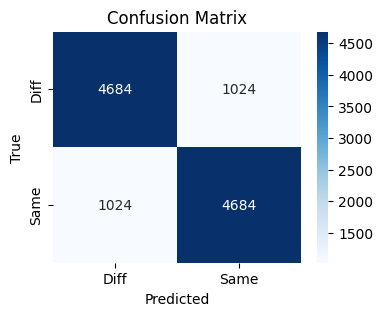

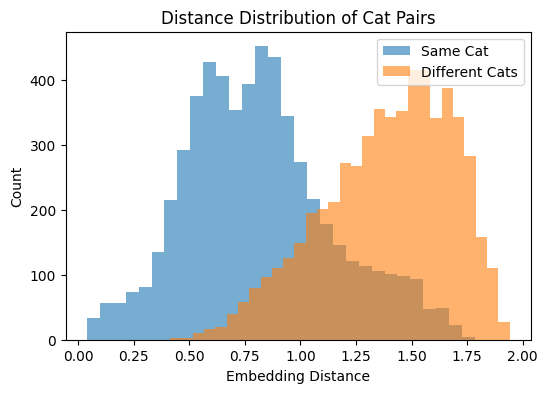

In [19]:
acc, auc, pos_dists, neg_dists, threshold = evaluate_embeddings(model, val_dataset, n_pairs=None)

✅ Evaluation (unique images):
  Cats: 13 | Unique images: 76
  Positive pairs: 188 | Negative pairs: 188
  Acc: 0.771 | AUC: 0.859 | Prec: 0.771 | Rec: 0.771 | F1: 0.771
  Threshold used: 1.118


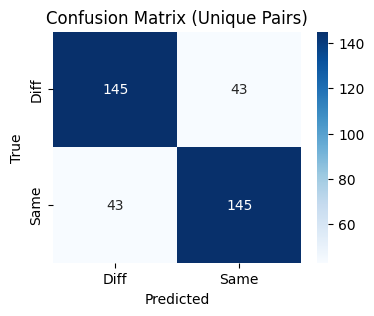

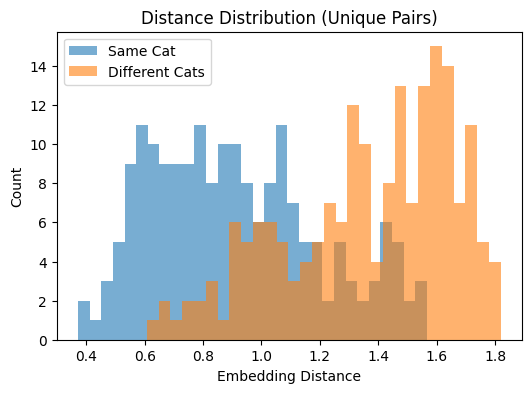

,Image1,Image2,ErrorType,Distance,DistFromThreshold
47,000029\00.png,000025\01.png,False Positive,0.607502,0.510134
64,000025\01.png,000030\05.png,False Positive,0.652601,0.465035
35,000033\02.png,000033\06.png,False Negative,1.566902,0.449266
58,000033\02.png,000007\05.png,False Positive,0.675690,0.441946
13,000057\04.png,000057\06.png,False Negative,1.546052,0.428416
39,000033\05.png,000033\06.png,False Negative,1.538827,0.421191
71,000033\05.png,000025\03.png,False Positive,0.710770,0.406866
32,000033\00.png,000033\06.png,False Negative,1.509261,0.391624
38,000033\03.png,000033\05.png,False Negative,1.491166,0.373529
68,000007\05.png,000025\00.png,False Positive,0.749294,0.368342


💾 Saved misclassified pairs to misclassified_pairs_unique.csv


In [20]:
import torch, os, random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from itertools import combinations
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

@torch.no_grad()
def evaluate_embeddings_unique(model, dataset, max_pos_per_cat=None, balance_negatives=True,
                               log_errors=True, save_csv=True, seed=42):
    """
    Evaluate using UNIQUE image pairs (not triplet indices).
    - max_pos_per_cat: cap #positive pairs sampled per cat (None = all combos)
    - balance_negatives: sample same number of negatives as positives
    """
    rng = random.Random(seed)
    np.random.seed(seed)

    model.eval()
    model.to(DEVICE)

    # 1) collect UNIQUE image paths per cat from the triplets
    # triplet format is (anchor_path, positive_path, negative_path) relative to DATA_DIR
    cat_to_imgs = {}
    for a, p, n in dataset.triplets:
        cat_a = a.split(os.sep)[0]
        cat_p = p.split(os.sep)[0]
        cat_to_imgs.setdefault(cat_a, set()).update([a, p])
        cat_to_imgs.setdefault(cat_p, set()).update([a, p])  # same cat as anchor/positive

    # 2) embed each unique image ONCE (cache)
    all_paths = sorted({img for imgs in cat_to_imgs.values() for img in imgs})
    path_to_emb = {}
    for rel_path in all_paths:
        img = Image.open(os.path.join(dataset.data_dir, rel_path)).convert("RGB")
        x = dataset.transform(img).unsqueeze(0).to(DEVICE)
        path_to_emb[rel_path] = model(x).cpu().numpy().squeeze()

    # 3) build positive pairs from UNIQUE images only
    pos_pairs, pos_dists = [], []
    for cat, imgs_set in cat_to_imgs.items():
        imgs = sorted(list(imgs_set))
        if len(imgs) < 2:
            continue
        combos = list(combinations(imgs, 2))
        rng.shuffle(combos)
        if max_pos_per_cat is not None:
            combos = combos[:max_pos_per_cat]
        for p1, p2 in combos:
            d = np.linalg.norm(path_to_emb[p1] - path_to_emb[p2])
            pos_pairs.append((p1, p2))
            pos_dists.append(d)

    # 4) sample negatives (different cats)
    neg_pairs, neg_dists = [], []
    cats = list(cat_to_imgs.keys())
    neg_target = len(pos_pairs) if balance_negatives else len(pos_pairs) // 2
    while len(neg_pairs) < neg_target and len(cats) >= 2:
        c1, c2 = rng.sample(cats, 2)
        i1 = rng.choice(list(cat_to_imgs[c1]))
        i2 = rng.choice(list(cat_to_imgs[c2]))
        d = np.linalg.norm(path_to_emb[i1] - path_to_emb[i2])
        neg_pairs.append((i1, i2))
        neg_dists.append(d)

    # 5) metrics
    distances = np.array(pos_dists + neg_dists)
    labels = np.concatenate([np.ones(len(pos_dists)), np.zeros(len(neg_dists))]).astype(int)

    # use median as default threshold (or tune separately if you want)
    threshold = np.median(distances)
    preds = (distances < threshold).astype(int)

    acc = accuracy_score(labels, preds)
    auc = roc_auc_score(labels, -distances) if len(np.unique(labels)) > 1 else np.nan
    prec = precision_score(labels, preds)
    rec = recall_score(labels, preds)
    f1 = f1_score(labels, preds)
    cm = confusion_matrix(labels, preds)

    print("✅ Evaluation (unique images):")
    print(f"  Cats: {len(cat_to_imgs)} | Unique images: {len(all_paths)}")
    print(f"  Positive pairs: {len(pos_pairs)} | Negative pairs: {len(neg_pairs)}")
    print(f"  Acc: {acc:.3f} | AUC: {auc:.3f} | Prec: {prec:.3f} | Rec: {rec:.3f} | F1: {f1:.3f}")
    print(f"  Threshold used: {threshold:.3f}")

    # confusion matrix
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Diff','Same'], yticklabels=['Diff','Same'])
    plt.title('Confusion Matrix (Unique Pairs)')
    plt.xlabel('Predicted'); plt.ylabel('True')
    plt.show()

    # histograms
    plt.figure(figsize=(6,4))
    plt.hist(pos_dists, bins=30, alpha=0.6, label='Same Cat')
    plt.hist(neg_dists, bins=30, alpha=0.6, label='Different Cats')
    plt.xlabel('Embedding Distance'); plt.ylabel('Count'); plt.legend()
    plt.title('Distance Distribution (Unique Pairs)')
    plt.show()

    # 6) optional: log mistakes with how wrong they were
    if log_errors:
        wrong_rows = []
        for (p1, p2), y, yhat, d in zip(pos_pairs + neg_pairs, labels, preds, distances):
            if y != yhat:
                wrong_rows.append({
                    "Image1": p1, "Image2": p2,
                    "ErrorType": "False Negative" if y==1 else "False Positive",
                    "Distance": d, "DistFromThreshold": abs(d - threshold)
                })
        if wrong_rows:
            df = pd.DataFrame(wrong_rows).sort_values("DistFromThreshold", ascending=False)
            display(df.head(10))
            if save_csv:
                df.to_csv("misclassified_pairs_unique.csv", index=False)
                print("💾 Saved misclassified pairs to misclassified_pairs_unique.csv")
        else:
            print("🎯 No misclassified pairs!")

    return acc, auc, threshold
    
acc, auc, threshold = evaluate_embeddings_unique(
    model, 
    val_dataset,
    max_pos_per_cat=50,        # limit same-cat pairs per cat
    balance_negatives=True,    # sample equal number of negatives
    log_errors=True,           # print top-10 wrong pairs
    save_csv=True              # save all misclassified to CSV
)


Running t-SNE (this can take ~30s)...


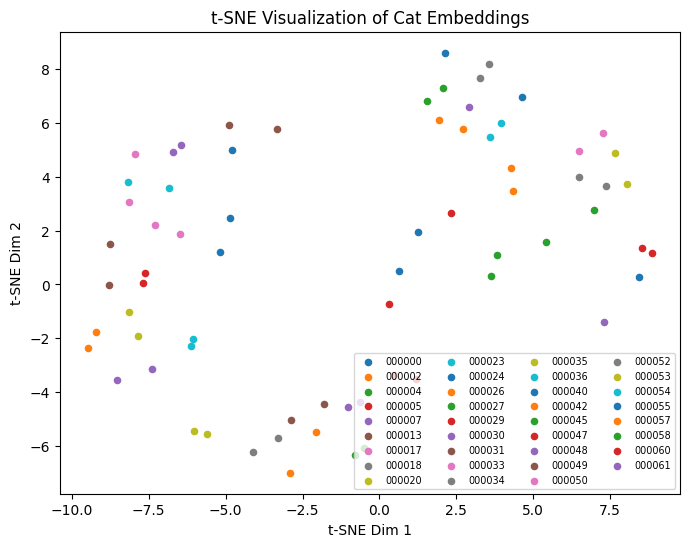

In [21]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm import tqdm
import os

@torch.no_grad()
def extract_cat_embeddings(model, dataset, max_images_per_cat=5):
    """
    Extract embeddings per cat for visualization (limited per cat for clarity).
    """
    model.eval()
    model.to(DEVICE)

    cat_to_indices = {}
    for idx in range(len(dataset)):
        folder = dataset.triplets[idx][0].split(os.sep)[0]
        cat_to_indices.setdefault(folder, []).append(idx)

    embs, labels = [], []
    for cat, indices in cat_to_indices.items():
        # limit images per cat for readability
        indices = indices[:max_images_per_cat]
        for idx in indices:
            a, _, _ = dataset[idx]
            e = model(a.unsqueeze(0).to(DEVICE)).cpu().numpy().squeeze()
            embs.append(e)
            labels.append(cat)

    return np.array(embs), np.array(labels)

# --- extract embeddings for visualization ---
embs, labels = extract_cat_embeddings(model, val_dataset)

# --- compute t-SNE projection ---
print("Running t-SNE (this can take ~30s)...")
tsne = TSNE(n_components=2, random_state=42, perplexity=15)
embs_2d = tsne.fit_transform(embs)

# --- visualize ---
plt.figure(figsize=(8,6))
unique_labels = np.unique(labels)
for cat in unique_labels:
    idx = labels == cat
    plt.scatter(embs_2d[idx,0], embs_2d[idx,1], s=20, label=cat)

plt.legend(fontsize='x-small', ncol=4)
plt.title("t-SNE Visualization of Cat Embeddings")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.show()


Real Image

In [10]:
from PIL import Image

def compare_two_images(model, img_path1, img_path2):
    model.eval()
    transform_eval = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485,0.456,0.406],
                             std=[0.229,0.224,0.225])
    ])
    img1 = transform_eval(Image.open(img_path1).convert("RGB")).unsqueeze(0).to(DEVICE)
    img2 = transform_eval(Image.open(img_path2).convert("RGB")).unsqueeze(0).to(DEVICE)

    emb1 = model(img1)
    emb2 = model(img2)
    dist = torch.nn.functional.pairwise_distance(emb1, emb2).item()
    print(f"Distance: {dist:.4f}")
    if dist < 0.8:
        print("✅ Likely the same cat")
    else:
        print("❌ Different cats")


In [ ]:
compare_two_images(model, "data/000001/00.png", "data/000001/03.png")